### Kuramoto Sivashinsky (regular) equation in JAX

$\begin{aligned}
    &u_t + \alpha uu_x + \beta u_{xx} + \gamma u_{xxxx} = 0 \\
    &\alpha = 5, \beta = 0.5, \gamma = 0.005 \\
    &u_0(x) = -\sin (\pi x) 
\end{aligned}$

In [1]:
import jax 
import jax.numpy as jnp
from jax.experimental.jet import jet
import numpy as np
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import scipy
import matplotlib.pyplot as plt
import pickle
import copy
import time
from tqdm import trange
from typing import Sequence
from functools import partial
from multiprocessing import Pool

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
M = 5
L = 2.0
layer_sizes = [2*M+1] + [256] * 3 + [1]

class Net(nn.Module):
    layer_sizes: Sequence[int]
    M: int
    L: float

    def setup(self):
        self.W1 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.W2 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.Wz = [nn.Dense(features=size, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()) for size in self.layer_sizes[1:]]
        
    def input_encoding(self, x):
        w = 2 * jnp.pi / L
        k = jnp.arange(1, M + 1)
        return jnp.hstack([jnp.ones(x.shape), jnp.cos(k*w*x), jnp.sin(k*w*x)])

    def __call__(self, x):
        X = self.input_encoding(x)
        U = nn.tanh(self.W1(X))
        V = nn.tanh(self.W2(X))

        H = nn.tanh(self.Wz[0](X))
        for linear in self.Wz[1:-1]:
            Z = nn.tanh(linear(H))
            H = jnp.multiply(1 - Z, U) + jnp.multiply(Z, V)
        return self.Wz[-1](H)

net = Net(layer_sizes, M, L)

In [3]:
def mse_fn(true, pred):
    return jnp.mean(jnp.square(true - pred))

def diff(func, argnums):
    return jax.grad(lambda *ar, **kw: jnp.sum(func(*ar, **kw)), argnums=argnums)

@jax.jit
def train_step_u0(state, x_r, x_du0, u_true, du_true):
    def loss_fn(params):
        u_fn = lambda x: state.apply_fn(params, x)
        du_x = diff(u_fn, 0)
        loss_f = 1000*mse_fn(u_true, u_fn(x_r))
        loss_d = mse_fn(du_true, du_x(x_du0))
        
        loss = loss_f + loss_d
        return loss, (loss_f, loss_d)
    grads, (loss_f, loss_d) = jax.grad(loss_fn, argnums=0, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_f, loss_d

@jax.jit
def train_step_rest(state, x, uk, duk_x, duk_xx, duk_xxx, duk_xxxx, N_t):
    def loss_fn(params):
        u_fn = lambda x: state.apply_fn(params, x)
        _, (du_x, du_xx, du_xxx, du_xxxx) = jet(u_fn, (x, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
        u = u_fn(x)

        # u_fn = lambda x: state.apply_fn(params, x)
        # du_x_fn = diff(u_fn, 0)
        # du_xx_fn = diff(du_x_fn, 0)
        # du_xxx_fn = diff(du_xx_fn, 0)
        # du_xxxx_fn = diff(du_xxx_fn, 0)
        # u = u_fn(x)
        # du_x = du_x_fn(x)
        # du_xx = du_xx_fn(x)
        # du_xxx = du_xxx_fn(x)
        # du_xxxx = du_xxxx_fn(x)

        loss = mse_fn((u-uk)/(1/N_t), -5*(u+uk)/2*(du_x+duk_x)/2 - 0.5*(du_xx+duk_xx)/2 - 0.005*(du_xxxx+duk_xxxx)/2)
        return loss, loss
    grads, loss = jax.grad(loss_fn, argnums=0, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [4]:
# u(x, 0) 
def U_x0(x):
    return -jnp.sin(jnp.pi*x)

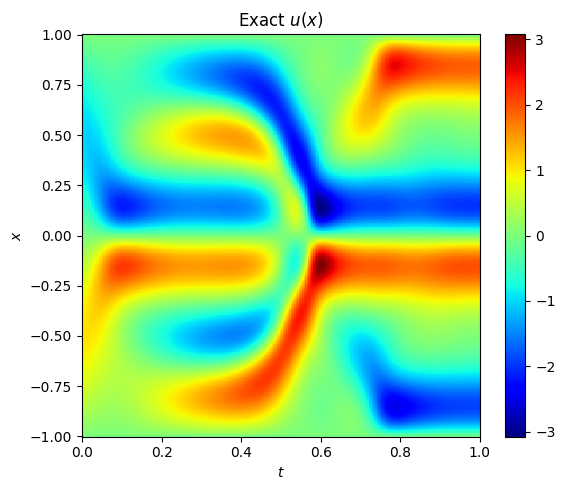

In [5]:
dtdt = 4
N_t = 250*dtdt
N_x = 512
key = jax.random.PRNGKey(2023)
key, skey = jax.random.split(key)
dummy_x = jax.random.uniform(skey, (N_x, 1))
key, skey = jax.random.split(skey)
params = net.init(skey, dummy_x)

# Load the data and grid
data = scipy.io.loadmat('ks_simple.mat')
usol = data['usol']
t_star = data['t'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Plot the reference solution
fig = plt.figure(figsize=(6, 5))
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

# Sample points
X_r   = np.linspace(-1, 1, N_x).reshape(-1, 1)              # used to train u
X_du0 = np.linspace(-1, 1, N_x).reshape(-1, 1)[1:-1:1]      # used to train u_t
X_star= x_star.reshape(-1, 1)                               # used to predict
u0    = U_x0(X_r)                                           # reference solution of u(x, 0) when training
du0_x = diff(U_x0, 0)(X_du0)                                # reference solution of u_t(x, 0) when training
usol0 = usol[:,0].reshape(-1, 1)                            # reference solution of u(x, 0) when predicting

In [6]:
# Train u0
start_time = time.time()
print('Training u0')

#logger
loss_f_log = []
loss_d_log = []
l2_error_log = []
u_pred = []
l2_each_tn_log = []

# optimizer & schedule
lr = 1e-2
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.95
)
optimizer = optax.adam(learning_rate=schedule)

# Train state
state = train_state.TrainState.create(apply_fn=net.apply, params=params, tx=optimizer)

# Load state
# pkl_file = pickle.load(open('Allen_Cahn/states/state{:d}.pkl'.format(0), 'rb'))
# state = flax.serialization.from_state_dict(state, pkl_file)

pbar = trange(1, 10000 + 1, ncols=150)
loss_min = 1e8
for nIter in pbar:
    state, loss_f, loss_d = train_step_u0(state, X_r, X_du0, u0, du0_x)
    loss = loss_f + loss_d

    # Save the best state
    if loss < loss_min:
        state_dict = flax.serialization.to_state_dict(state)
        pickle.dump(state_dict, open('states/state{:d}.pkl'.format(0), 'wb'))
        loss_min = loss
    
    if nIter % 1000 == 0:
        l2_error = jnp.linalg.norm(usol0 - state.apply_fn(state.params, X_star)) / jnp.linalg.norm(usol0)

        loss_f_log.append(loss_f)
        loss_d_log.append(loss_d)
        l2_error_log.append(l2_error)
        pbar.set_postfix_str('loss:{:.2e}, loss_f:{:.2e}, loss_d:{:.2e}, l2_error:{:.2e}, loss_min:{:.2e}'.format(loss, loss_f, loss_d, l2_error, loss_min))

# Load the best state
pkl_file = pickle.load(open('states/state{:d}.pkl'.format(0), 'rb'))
state = flax.serialization.from_state_dict(state, pkl_file)
u_pred.append(state.apply_fn(state.params, X_star))
l2_each_tn_log.append(jnp.linalg.norm(usol[:,0:1] - u_pred[-1]) / jnp.linalg.norm(usol[:,0:1]))
elapsed_u0 = time.time() - start_time

Training u0


100%|███████████████████| 10000/10000 [00:21<00:00, 458.11it/s, loss:7.93e-07, loss_f:1.43e-07, loss_d:6.50e-07, l2_error:1.69e-05, loss_min:7.85e-07]


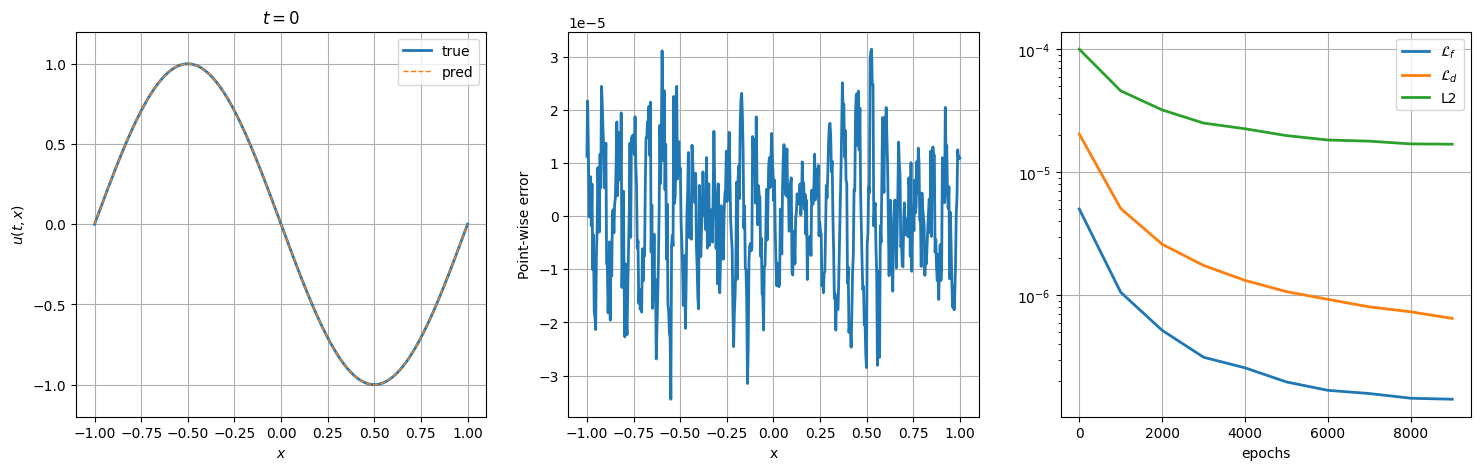

u0 training time: 22 s


In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.set_ylim(-1.2, 1.2)
ax1.plot(X_star, usol[:,0], label='true', linewidth=2)
ax1.plot(X_star, u_pred[0], label='pred', linewidth=1, linestyle='--')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u(t, x)$')
ax1.set_title('$t = 0$')
ax1.legend()
ax1.grid(True)

ax2.ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
ax2.plot(X_star, usol0- u_pred[0], linewidth=2)
ax2.set_xlabel('x')
ax2.set_ylabel('Point-wise error')
ax2.grid(True)

plt.yscale('log')
ax3.plot(1000*np.arange(len(loss_f_log)), loss_f_log, label='$\mathcal{L}_{f}$', linewidth=2)
ax3.plot(1000*np.arange(len(loss_d_log)), loss_d_log, label='$\mathcal{L}_{d}$', linewidth=2)
ax3.plot(1000*np.arange(len(l2_error_log)), l2_error_log, label='L2', linewidth=2)
ax3.set_xlabel('epochs')
ax3.legend()
ax3.grid(True)
plt.show()

print('u0 training time: {:.0f} s'.format(elapsed_u0))

In [8]:
# Train u1 u2 u3 ...
start_time_rest = time.time()
print('Training u1 u2 u3 ...')

# logger
steps_each_tn_log = []
loss_each_tn_log = []
loss_log = []
loss_min_log = []

# New optimizer & schedule
lr = 1e-4
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.9
)
optimizer = optax.adam(learning_rate=schedule)

pbar = trange(1, N_t + 1, ncols=120)
for t_n in pbar:
    loss_last = 0
    loss_min = 1e8
    loss_patience = 0
    loss_each_tn_log = []

    # Use known Initial Condition when training u1
    if t_n == 1:
        _, (duk_x, duk_xx, duk_xxx, duk_xxxx) = jet(U_x0, (X_r, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
        uk = U_x0(X_r)
    else:
        uk_fn = lambda x: state.apply_fn(state.params, x)
        _, (duk_x, duk_xx, duk_xxx, duk_xxxx) = jet(uk_fn, (X_r, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD
        uk = uk_fn(X_r)

    # if t_n == 1:
    #     uk_fn = lambda x: U_x0(x)
    # else:
    #     uk_fn = lambda x: state.apply_fn(state.params, x)
    # duk_x_fn = diff(uk_fn, 0)
    # duk_xx_fn = diff(duk_x_fn, 0)
    # duk_xxx_fn = diff(duk_xx_fn, 0)
    # duk_xxxx_fn = diff(duk_xxx_fn, 0)
    # uk = uk_fn(X_r)
    # duk_x = duk_x_fn(X_r)
    # duk_xx = duk_xx_fn(X_r)
    # duk_xxx = duk_xxx_fn(X_r)
    # duk_xxxx = duk_xxxx_fn(X_r)

    # uk_fn = lambda x: state.apply_fn(state.params, x)
    # uk, (duk_x, duk_xx, duk_xxx, duk_xxxx) = jet(uk_fn, (X_r, ), [[1.0, 0.0, 0.0, 0.0]]) #  Taylor-mode AD

    # Renew train state
    state = train_state.TrainState.create(apply_fn=net.apply, params=state.params, tx=optimizer)

    for steps in range(1, 10000 + 1):
        state, loss = train_step_rest(state, X_r, uk, duk_x, duk_xx, duk_xxx, duk_xxxx, N_t)
        pbar.set_postfix_str('steps:{:4d}, loss:{:.5e}, min:{:.5e}, l2_last:{:.2e}'.format(steps, loss, loss_min, l2_each_tn_log[-1]))
        loss_each_tn_log.append(loss)

        # Save the best state
        if loss < loss_min:
            state_dict = flax.serialization.to_state_dict(state)
            pickle.dump(state_dict, open('states/state{:d}.pkl'.format(t_n), 'wb'))
            loss_min = loss 
            loss_patience = steps

        # Determine whether to proceed to the next time step
        if steps>1000 and loss<1e-2 and (0<loss_last-loss<=1e-8 or steps-loss_patience>200):
            break
        loss_last = loss

    # Load the best state
    pkl_file = pickle.load(open('states/state{:d}.pkl'.format(t_n), 'rb'))
    state = flax.serialization.from_state_dict(state, pkl_file)
    if t_n % dtdt == 0:
        u_pred.append(state.apply_fn(state.params, X_star))
        t_index = int(t_n/dtdt)
        usol_tn = usol[:,t_index:t_index+1]
        l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))

    # Log 
    steps_each_tn_log.append(steps)
    loss_min_log.append(loss_min)
    loss_log.append(loss_each_tn_log)

elapsed_rest = time.time() - start_time_rest

Training u1 u2 u3 ...


100%|████████████| 1000/1000 [1:23:47<00:00,  5.03s/it, steps:1001, loss:8.89321e-04, min:8.46166e-04, l2_last:2.09e-02]


In [39]:
# Save data
path = 'result_cn'
pickle.dump(u_pred, open(f'{path}/u_pred.pkl', 'wb'))
pickle.dump(loss_log, open(f'{path}/loss.pkl', 'wb'))
pickle.dump(loss_min_log, open(f'{path}/loss_min.pkl', 'wb'))
pickle.dump(l2_each_tn_log, open(f'{path}/l2_each_tn.pkl', 'wb'))
pickle.dump(steps_each_tn_log, open(f'{path}/steps_each_tn.pkl', 'wb'))

In [6]:
# Load data
# path = 'result_cn'
# u_pred = pickle.load(open(f'{path}/u_pred.pkl', 'rb'))
# loss_log = pickle.load(open(f'{path}/loss.pkl', 'rb'))
# loss_min_log = pickle.load(open(f'{path}/loss_min.pkl', 'rb'))
# l2_each_tn_log = pickle.load(open(f'{path}/l2_each_tn.pkl', 'rb'))
# steps_each_tn_log = pickle.load(open(f'{path}/steps_each_tn.pkl', 'rb'))

In [11]:
# Load states, predict, compute L2 error
# schedule = optax.exponential_decay(init_value=1e-3, transition_steps=100, decay_rate=0.9)
# optimizer = optax.adam(learning_rate=schedule)
# state = train_state.TrainState.create(apply_fn=net.apply, params=params, tx=optimizer)
# l2_each_tn_log = []
# u_pred = []
# for t_n in range(0, N_t+1):
#     if t_n % dtdt == 0:
#         pkl_file = pickle.load(open('states/state{:d}.pkl'.format(t_n), 'rb'))
#         state = flax.serialization.from_state_dict(state, pkl_file)

#         u_pred.append(state.apply_fn(state.params, X_star)[:,-1:])
#         t_index = int(t_n/dtdt)
#         usol_tn = usol[:,t_index:t_index+1]
#         l2_each_tn_log.append(jnp.linalg.norm(usol_tn - u_pred[-1]) / jnp.linalg.norm(usol_tn))
# print(len(l2_each_tn_log))
# print(len(u_pred))

In [7]:
u_pred_copy = copy.deepcopy(u_pred)

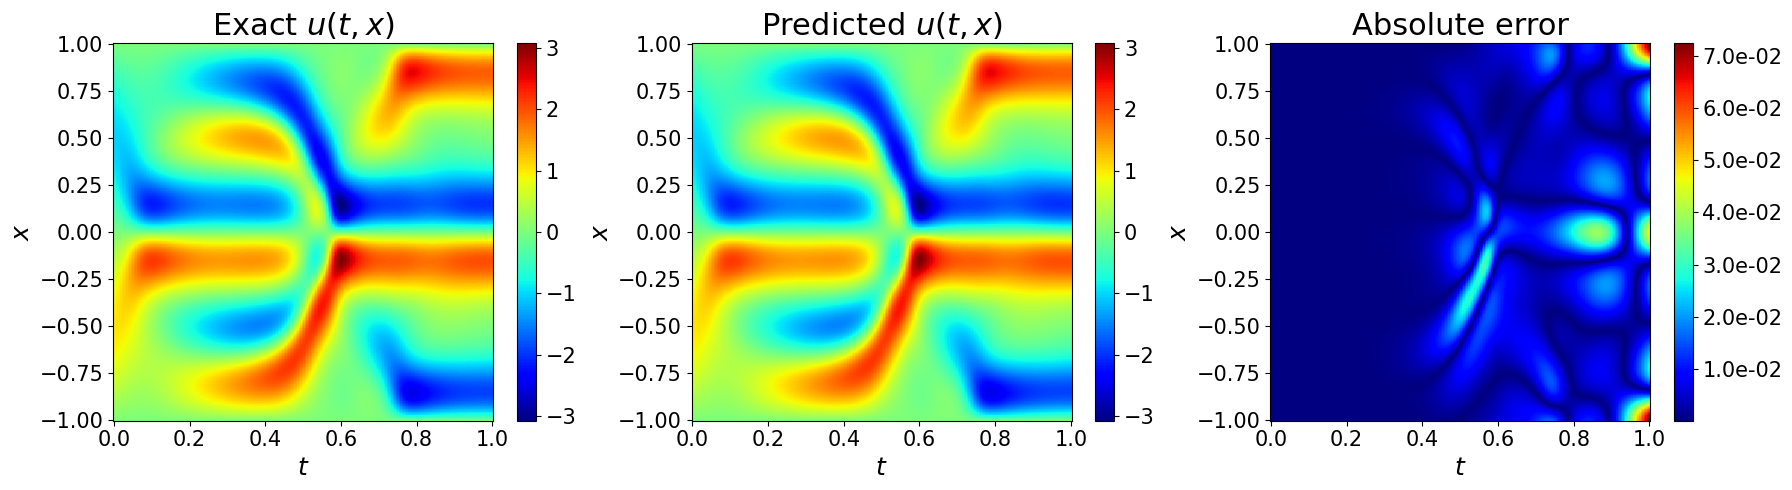

In [8]:
# reshape to the same format & compute L2 error
u_pred = copy.deepcopy(u_pred_copy)
u_pred = np.reshape(u_pred, (len(usol[0]), len(usol))).T
l2_error = np.linalg.norm(usol - u_pred) / np.linalg.norm(usol)

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(r'Exact $u(t,x)$', fontsize=22)
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(r'Predicted $u(t,x)$', fontsize=22)
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
cbar = plt.colorbar(format='%1.1e')
cbar.ax.tick_params(labelsize=15)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Absolute error', fontsize=22)
plt.tight_layout()

plt.show()

print('training time after u0: {:.0f} s'.format(elapsed_rest))
print('total time: {:.0f} s'.format(elapsed_u0+elapsed_rest))
print('L2 error = {:.5e}'.format(l2_error))

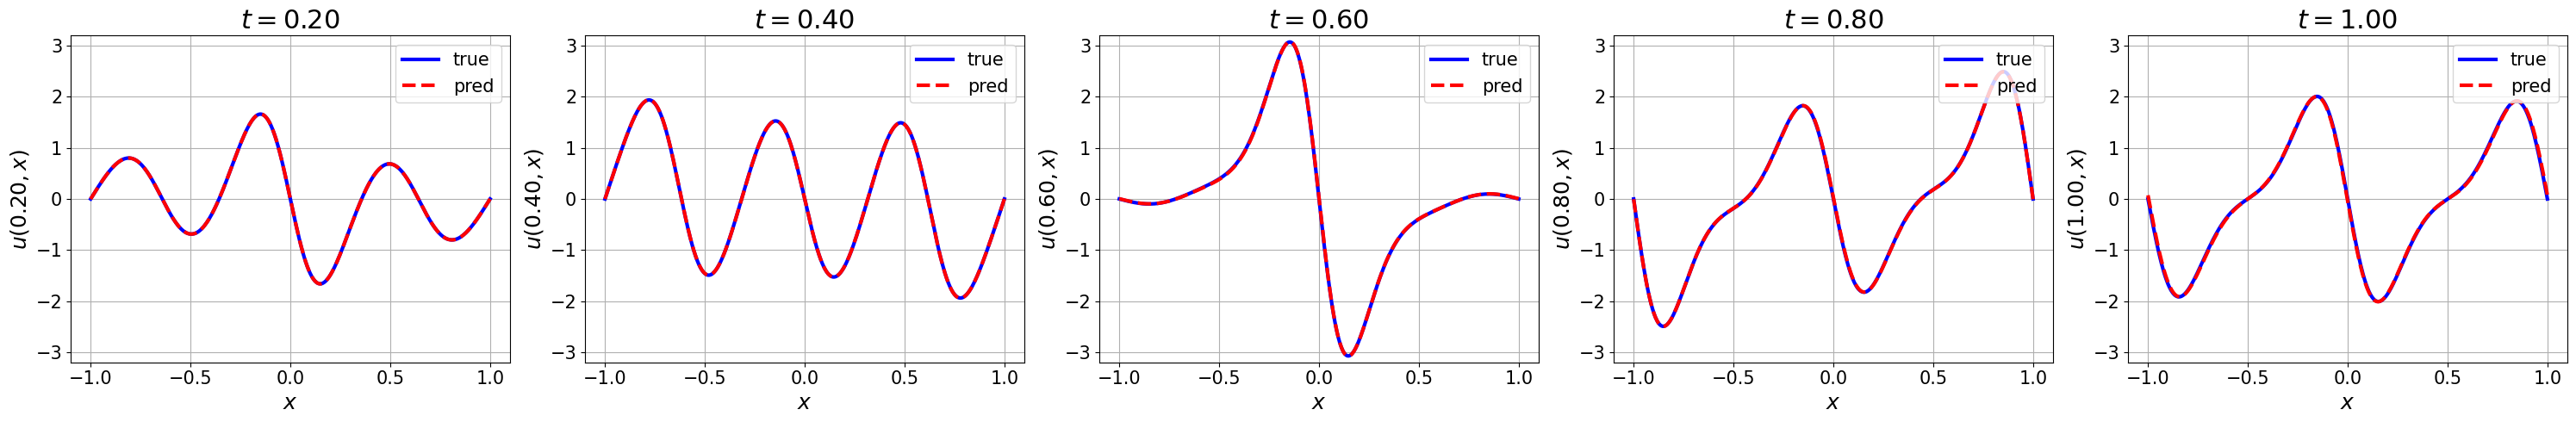

In [44]:
# point wise plot of several time stamps
fig = plt.figure(figsize=(30, 5))
for t in range(1, 6):
    plt.subplot(1, 5, t)
    plt.plot(X_r, usol[:, 50*t:50*t+1], label='true', color='blue', linestyle='-', linewidth=3)
    plt.plot(X_r, u_pred[:, 50*t:50*t+1], label='pred', color='red', linestyle='--', linewidth=3)
    plt.xlabel('$x$', fontsize=18)
    plt.ylabel('$u({:1.2f},x)$'.format(t/5), fontsize=18)
    plt.xticks(ticks=np.arange(-1,1.5,0.5) ,size=15)
    plt.yticks(ticks=np.arange(-3,3.5,1.0) ,size=15)
    plt.ylim(-3.2, 3.2)
    plt.title('$t={:1.2f}$'.format(t/5), fontsize=22)
    plt.legend(fontsize=15, loc='upper right')
    plt.grid(True)
    plt.tight_layout()

plt.show()

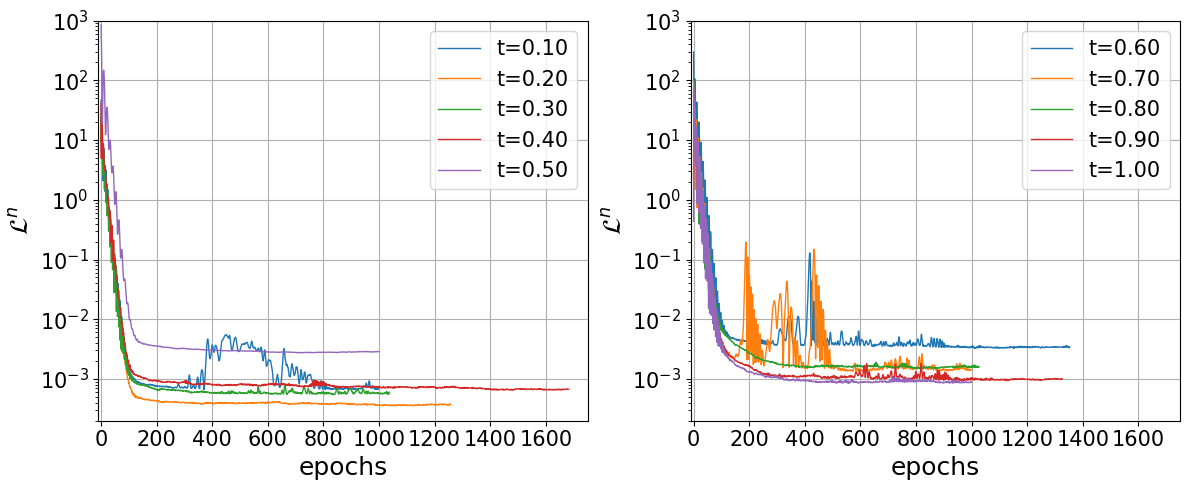

In [43]:
# Loss values of several time stamps
loss_plot = loss_log[25*dtdt-1::dtdt*25]

fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.xlim(-10, 1750)
plt.ylim(2e-4, 1e3)
for t in range(0, 5):
    plt.plot(np.arange(len(loss_plot[t])), loss_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('$\mathcal{L}^{n}$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15, loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.xlim(-10, 1750)
plt.ylim(2e-4, 1e3)
for t in range(5, 10):
    plt.plot(np.arange(len(loss_plot[t])), loss_plot[t], label='t={:.2f}'.format((t+1)/10), linewidth=1)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('$\mathcal{L}^{n}$', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15, loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

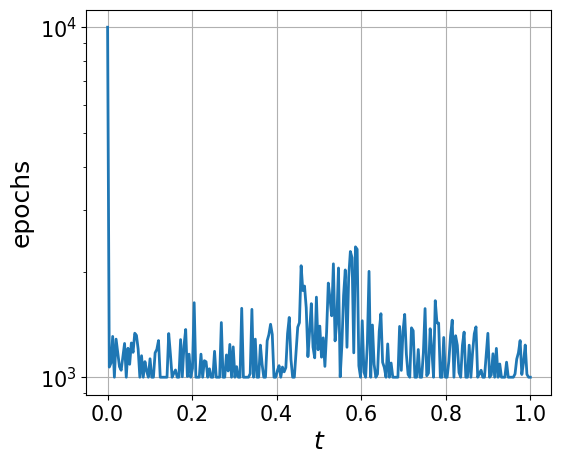

In [38]:
fig = plt.figure(figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.yscale('log')
plt.plot(np.linspace(0, 1, len(steps_each_tn_log[::4])), steps_each_tn_log[::4], linewidth=2)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('epochs', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(True)

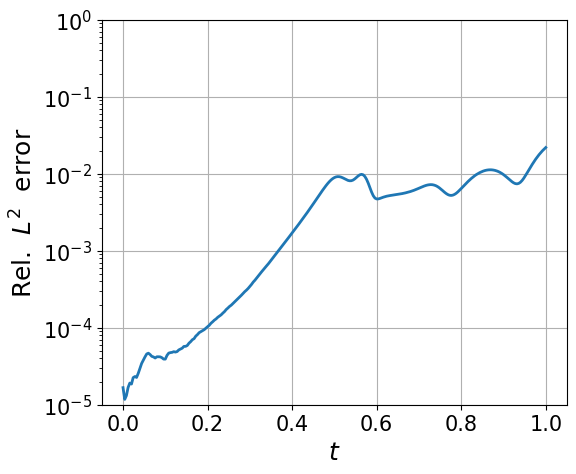

In [33]:
fig = plt.figure(figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.yscale('log')
plt.ylim(1e-5, 1)
plt.plot(np.linspace(0, 1, len(l2_each_tn_log)), l2_each_tn_log, linewidth=2)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('Rel.  $L^2$  error', fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(True)

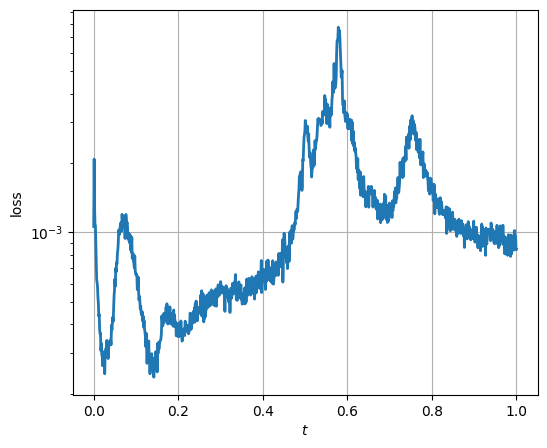

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.linspace(0, 1, len(loss_min_log)), loss_min_log, linewidth=2)
ax.set_xlabel('$t$')
ax.set_ylabel('loss')
# ax.set_title('loss_min')
ax.grid(True)
plt.show()

In [ ]:
# plot for video
u_pred = np.array(u_pred_copy).squeeze().T
for t in range(251):
    plt.figure(figsize=(6, 5))
    plt.subplot(1, 1, 1)
    plt.ylim(-3, 3)
    plt.xlim(-1, 1)
    plt.plot(X_r, usol[:, t], label='true', color='blue', linestyle='-', linewidth=3)
    plt.plot(X_r, u_pred[:, t], label='pred', color='red', linestyle='--', linewidth=3)
    plt.xlabel('$x$')
    plt.ylabel('$u(x, t)$')
    plt.title(r'$t={:.2f}$'.format(t/250))
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()

    plt.savefig('./video_plot/image_{:d}'.format(t))

In [ ]:
# make video
import cv2
import os

image_folder = './video_plot/'
video_name = 'KSr_CN.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

for t in range(251):
    image = cv2.imread('./video_plot/image_{:d}.png'.format(t))
    video.write(image)

video.release()
cv2.destroyAllWindows()

# Convert to H264 codec
os.system(f'ffmpeg -i {video_name} -vcodec h264 H264_{video_name} -y')